# Особенности использования полносвязных нейросетей для распознавания изображений

## Распознаём изображения с помощью MLP

Стандартная архитектура MLP независимо от задачи имеет вид:

1. Входной слой.
2. Промежуточные слои.
3. Выходной слой.

Чтобы определить размер входного слоя, рассмотрим входные данные. Как и в практическом задании предыдущего модуля, используется датасет MNIST, состоящий из чёрно-белых рукописных цифр. Размер каждого изображения — 28х28 пикселей (px), то есть всего 784 значения в интервале от 0 до 1. Тогда входной слой должен ожидать тензор с 784 значениями.

## Базовая настройка

- Один скрытый слой — начать с простейшей нейросети и усложнить её, если она будет плохо распознавать цифры.
   
- В слое 512 нейронов — степень двойки, сопоставимая с количеством входных признаков.

Чёткого правила по выбору начального количества нейронов в скрытых слоях не существует, но есть советы от известных учёных в этой области. Например, в базовой настройке по совету Эндрю Ына мы взяли примерно столько же нейронов, сколько входных признаков.

```python
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),
    nn.ReLU(), # Стандартная функция активации скрытого слоя
    nn.Linear(512, 10),
    nn.LogSoftmax(dim=1), # Используется для классификации
)
```

Если обучить её и оценить результат на тестовом датасете, F1 и accuracy будут равны 0.98 — это отличный результат. Продолжая эксперименты, можно снизить количество нейронов в скрытом слое до 256 без потерь в точности. Тогда в выходной слой будет поступать 256 признаков.
В итоге получается, что модель с небольшим количеством параметров способна распознавать рукописные цифры с очень высокой точностью. Но поскольку «небольшое количество» — это оценочное суждение, рассчитаем точное число параметров, чтобы понимать, сколько их обычно в небольших полносвязных моделях.

Для этого нужно вернуться к архитектуре и посмотреть, какие слои содержат параметры:

- nn.Flatten() — изменение формы тензора, параметров нет.
   
- nn.Linear(28*28, 256 — учитываем оптимизацию!) — 28×28 входных признаков + 1 bias. Это 785. На выходе должно получиться 256, а значит, размер матрицы весов: 

$785 × 256 = 200 960.$
    
- nn.ReLU() — применение функции, параметров нет.
    
- nn.Linear(256, 10) — 256 + 1 bias. На выходе должно получиться 10, размер матрицы весов — 2570.
   
- nn.LogSoftmax(dim=1) — применение функции, параметров нет.

Сложим полученные числа: 200 960 + 2 570 = 203 530 признаков. Если каждый занимает 4 байта (float32), то на хранение всех признаков нужно чуть меньше мегабайта. Это действительно небольшая модель, она весит меньше стандартной современной фотографии.

## Распознавание в реальном мире

Переложим изученную успешную модель в более реалистичный проект. В реалистичном проекте:

- Изображения цветные.
  
- Изображения большие.

- Цифры на них могут быть повёрнуты и перевёрнуты.

## Распознавание цветных изображений

Цифры из датасета MNIST — чёрно-белые, одноканальные. Цветные изображения — трёхканальные RGB. Каждое чёрно-белое изображение из MNIST содержит 784 значения, а если количество каналов увеличится с 1 до 3, то значений станет 784 × 3 = 2352. Вот как это повлияет на архитектуру:

- В первом полносвязном слое будет 28×28×3 входных признаков и хотя бы 1024 нейрона в скрытом слое (для 784 признаков хватило 256 нейронов в скрытом слое, поэтому для 2352 взято не 2048, а 1024).
    
- Во втором полносвязном слое, соответственно, будет 1024 входных признака, 10 нейронов.

Новая архитектура выглядит так:

```python
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28*3, 1024),
    nn.ReLU(), 
    nn.Linear(1024, 10),
    nn.LogSoftmax(dim=1),
)
```

## Распознавание больших изображений

На изображении 28×28 px можно разглядеть только идеальные рукописные цифры без лишних шумов, потёртостей и смещений. В современных классификаторах всё чаще встречаются размеры 224×224 px, 381×381 px. Для распознавания цифр такие размеры излишни, поэтому обойдёмся 128×128 px — небольшим, но реалистичным размером изображения для классификации. Прикинем изменения в архитектуре:

- В первом полносвязном слое будет 128 × 128 × 3 = 49 152 входных признака, тогда количество нейронов в скрытом слое должно составлять по крайней мере сопоставимые 10 000.
  
- Во втором полносвязном слое, соответственно, будет 10 000 входных признаков, 10 нейронов.

Новая архитектура:

```python
model = nn.Sequential(
nn.Flatten(),
nn.Linear(128*128*3, 10000),
nn.ReLU(),
nn.Linear(10000, 10),
nn.LogSoftmax(dim=1),
)
```

## Распознавание повёрнутых изображений

На реальных изображениях объекты часто находятся под углом, отражены или повёрнуты. Оказывается, если в первоначальную модель классификатора с точностью 98% подать перевёрнутые цифры, то её точность (accuracy) упадёт до 0.33, а метрика F1 — до 0.29. При этом, кроме поворота, ничего не изменится. Если просто сместить цифру влево или вправо, точность тоже падает.

Если рассмотреть архитектуру модели, то становится очевидным, почему всё именно так. Входные признаки представляются не в виде 2D-матрицы, а как плоский список значений, поэтому нейроны «привыкают», что некоторые входные признаки почти никогда не нужны:

- пиксели в углах;
  
- пиксели по краям.

В них никогда не бывает важных признаков для распознавания цифры. Например, все первые значения — это верхний левый край изображения, где всегда только фон. Веса для них равны 0, потому что они никогда ни на что не влияют.

## Свёрточные нейронные сети

Свёрточные нейронные сети — это вид нейронных сетей, в архитектуре которых используются преимущественно свёрточные слои и блоки.

## Особенности свёрточных сетей

В отличие от полносвязных нейронных сетей, свёрточные обладают важными свойствами: 

- Инвариантность относительно изменения масштаба, сдвига и поворота объекта на изображении. Для свёрточной нейронной сети нет разницы, в какой точке изображения находится признак. Это связано с тем, что свёрточные слои работают с матрицами, а не с плоскими векторами.
  
- Количество параметров не зависит напрямую от количества входных признаков. К примеру, ниже представлен код модели, которая также состоит из двух слоёв, только первый из nn.Linear заменён на nn.Conv2d — тот самый свёрточный слой. Количество нейронов в этом слое — 512. Модель предназначена для работы с квадратными трёхканальными изображениями произвольного размера (например, 128х128х3).

In [2]:
import torch.nn as nn

model = nn.Sequential(
          nn.Conv2d(3, 512, 3), # мистический свёрточный слой
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(512, 10),
          nn.Softmax(dim=1),
        )

print("Количество весов нейросети = ", sum(p.numel() for p in model.parameters()))

Количество весов нейросети =  19466


## Операция свёртки и фильтры

Если задуматься о том, как люди видят объекты, то оказываются важными:

- Переходы от светлого к тёмному или между цветами. В зависимости от жёсткости такого перехода мы определяем его как границу — место, где заканчивается объект и начинается фон.
  
- Углы и линии — то, какими могут быть границы. Они складываются в контуры, по которым мы можем понять форму объекта и осознать, что это такое.

Переходы, углы и линии можно обозначить одним словом — признаки. Как и в других задачах машинного обучения, признаки — это то, что описывает входные данные. Если датасет — таблица информации о квартирах, то признаки — это значения из её столбцов: площадь, цена, количество комнат. Местоположение углов и линий — это признаки, которые описывают объекты на изображениях.

Чтобы научить компьютер видеть, нужно алгоритмизировать процесс выделения признаков из изображения. Когда есть признаки, работают уже знакомые методы (например, полносвязные нейронные сети).

Кстати, именно поэтому MLP сложно распознать изображение: в качестве признаков он получает значения пикселей. Ему приходится угадывать объект по набору точек разного цвета. Это похоже на попытку отгадать картинку по кусочкам невероятно мелкого пазла.

## Алгоритмизация выделения признаков

Существует математический способ поиска простых признаков (линий, углов) на изображении — наложение фильтра. Обычно под фильтрами понимают размытие фона, сглаживание неровностей кожи на фото и прочее. Однако у всех этих операций одинаковые механизмы работы, поэтому и то, и другое называется наложением фильтра. 

Алгоритм этой операции выглядит так:

- Представить исходное изображение в виде матрицы пикселей. Для простоты возьмём чёрно-белое изображение: 255 — белые пиксели, 0 — чёрные, остальные значения — оттенки серого между ними.

- Выбрать фильтр — матрицу 3×3 со специально подобранными значениями. Например, фильтр размытия — это матрица 3×3, заполненная значениями 1/9. Почему именно так? Подбирая разные значения, учёные выяснили, что именно 1/9 позволяют получить размытие.
  
- Определить на изображении скользящее окно размером с фильтр — тоже 3×3. Изначально оно находится в верхнем левом углу.
   
- Все значения пикселей, попавшие в скользящее окно, поэлементно умножить на значения фильтра. По сути, фильтр накладывается на изображение и умножает пиксели, попавшие под него.
    
- Суммировать полученные произведения. Записать в результат (изображение после фильтра).

- Сдвинуть окно на 1 пиксель вправо. Повторить шаги 4–5.

- Сдвинуть окно на 1 пиксель вниз. Повторить шаги 4–6.

- Если всё изображение было обработано скользящим окном, закончить.

**Фильтр** — это матрица со специально подобранными значениями, с помощью которой можно изменить изображение. Известно множество фильтров, и некоторые из них помогают выделить на изображении углы и линии — простые признаки, которые нужны для распознавания. Например, вертикальные и горизонтальные линии можно выделить так:

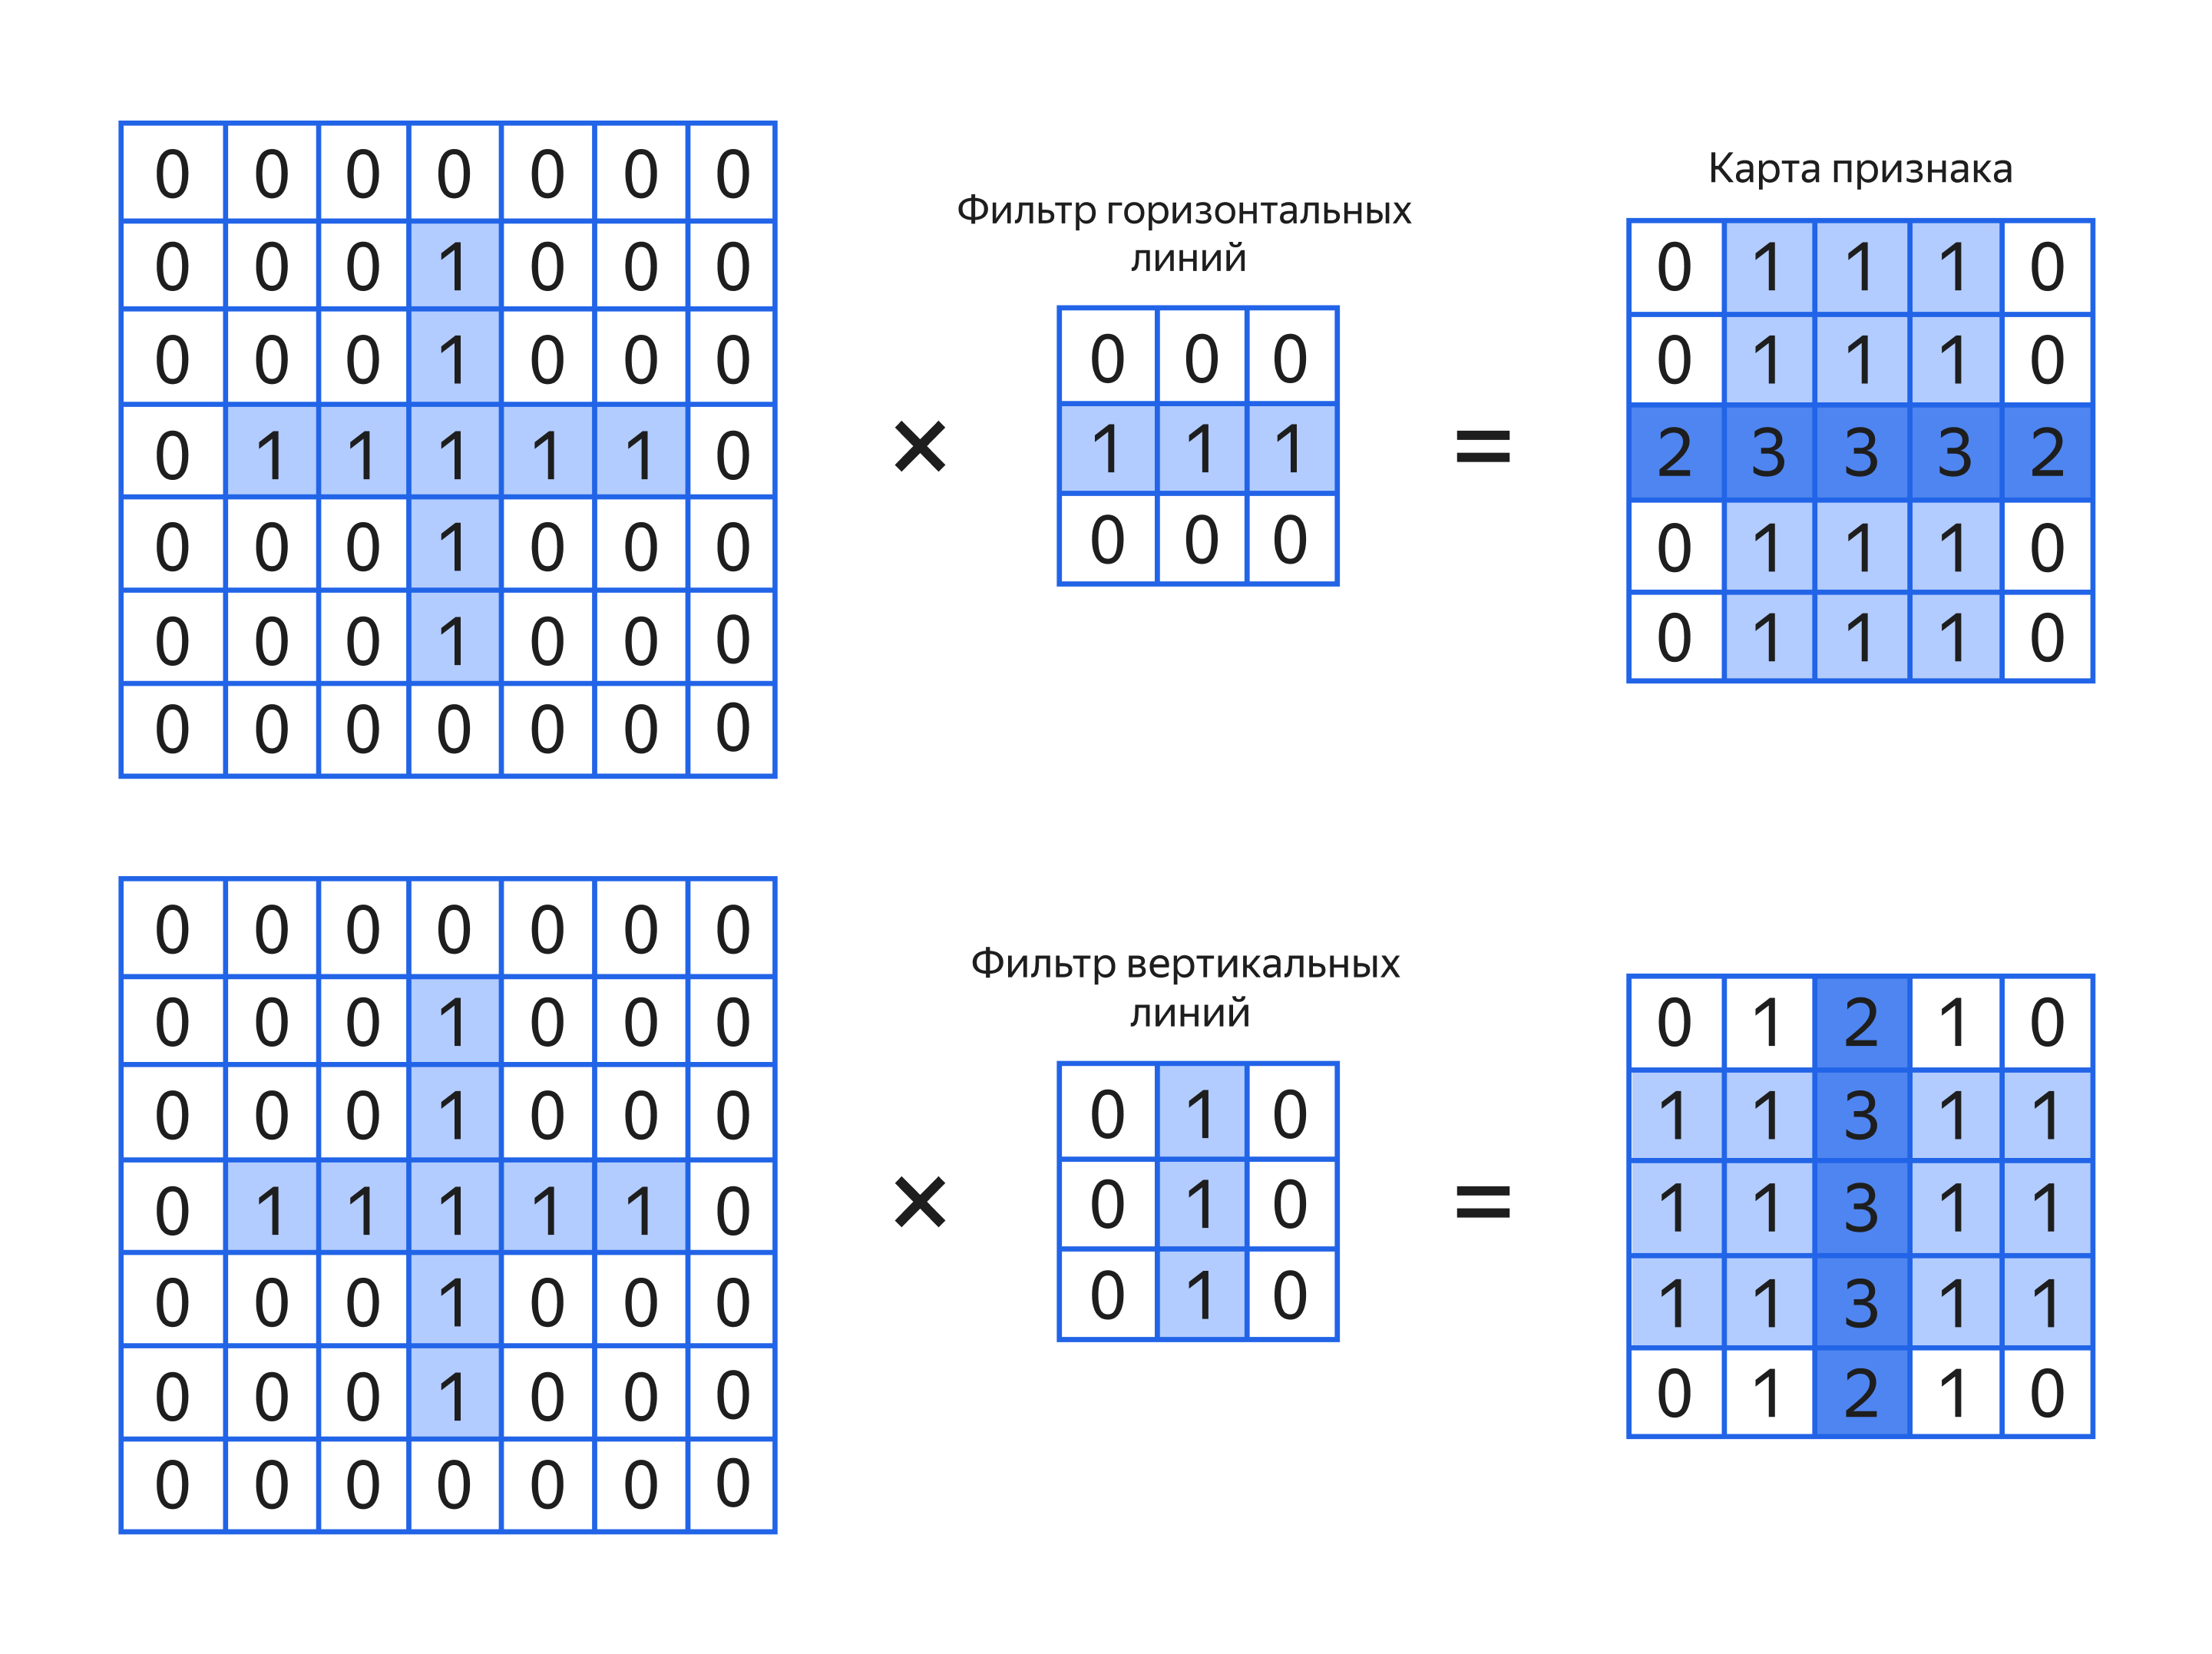

In [4]:
from IPython.display import Image
from ml_dl_experiments.settings import settings

picture: str = settings.SOURCE_PATH + "ml_dl/CNN/Filter.png"

Image(picture, width=600, height=600)

## Свёртка и карта признаков

По сути, алгоритм наложения фильтра на изображение, который мы разбирали ранее, представляет собой операцию свёртки. Свёртка — это обработка изображения с помощью фильтра, а результат её применения — так называемая карта признака.

Результат свёртки можно воспринимать двояко: 

- Визуально — как изображение после фильтра, потому что результат свёртки выглядит как изображение, на котором ярко выражен признак, соответствующий фильтру. Например, после свёртки фильтром вертикальных линий получится изображение с выделенными вертикалями.
   
- Математически, то есть как матрицу чисел. В ней есть большие числа — там, где на изображении был признак (например, вертикаль), и околонулевые — там, где признак не найден. С такой точки зрения матрицу можно интерпретировать как карту признака, ведь по ней можно ответить на вопросы:
    - Есть ли признак на изображении. К примеру, если на изображении нет вертикальных линий, то результатом применения фильтра вертикальных линий будет матрица нулей.
    
    - Если признак есть, то где он на изображении. Ненулевые точки на результате свёртки — это места, где на исходном изображении был обнаружен признак.

## Подбор значений фильтра

До машинного обучения люди выбирали важные, на их взгляд, признаки и составляли для них фильтры вручную. Теперь вся операция свёртки внедрена в нейросети как особый тип слоя — свёрточный nn.Conv2D(). Как и в полносвязном, в свёрточном слое может быть сколько угодно нейронов. Один нейрон — это один фильтр. Веса нейрона — это значения матрицы фильтра.

Как только изображение попадает в слой nn.Conv2D(), операция свёртки обрабатывает его столько раз, сколько в слое нейронов:

1. Один нейрон — одна операция свёртки — одна карта признаков на выходе.
2. Два нейрона — две операции свёртки — две карты признаков на выходе.
3. …

>Количество параметров свёрточного слоя равно произведению количества фильтров на количество значений в фильтре.

Получается, количество параметров не зависит от размера входного изображения. Именно поэтому количество параметров свёрточного слоя не возрастает при увеличении размера входа, как это было с полносвязным слоем.

Веса свёрточного слоя подбираются точно так же, как и веса полносвязного — с помощью алгоритма обратного распространения ошибки. По примерам нейросеть обучается, какие визуальные признаки важны для решения задачи и какими фильтрами их можно выделить.
Чем больше нейронов в слое, тем больше разных признаков он может выделить на изображении.

Чтобы выполнить операцию свёртки с собственным фильтром, используется функция nn.functional.conv2d(), которая принимает два аргумента:

- Изображения — передаются в тензоре с размерностью [количество изображений, количество цветовых каналов изображения, высота, ширина]. Для чёрно-белого изображения размером 28х28 (любая цифра из MNIST) это [1, 1, 28, 28].
    
    - Так как изображение по умолчанию загружается как тензор размерности [количество каналов, ширина, высота], например, [1, 28, 28], чтобы преобразовать его в требуемую форму [1, 1, 28, 28], нужно добавить к тензору ещё одно измерение. Это можно сделать с помощью метода .unsqueeze(0). 0 означает, что новое измерение будет добавлено как внешний слой: было тензор, стало [тензор].
    
    - Матрица фильтров — передаётся в тензоре с размерностью [количество фильтров, количество каналов изображения, ширина фильтра, высота фильтра]. Для одного кастомного фильтра 3х3 — это [1, 1, 3, 3].

```python
from PIL import Image
from torchvision.transforms.functional import to_tensor

image = Image.open("/data/img.png")
image_tensor = to_tensor(image) # тензор [1, 28, 28]

# добавляем ещё одно измерение, чтобы получить [1, 1, 28, 28]
image_tensor = image_tensor.unsqueeze(0) 

kernel = torch.Tensor([[[[3, 10, 3], 
                         [0, 0, 0], 
                         [-3, -10, -3]]]]) # некий фильтр размерности [1, 1, 3, 3]

result = torch.nn.functional.conv2d(image_tensor, kernel)
```

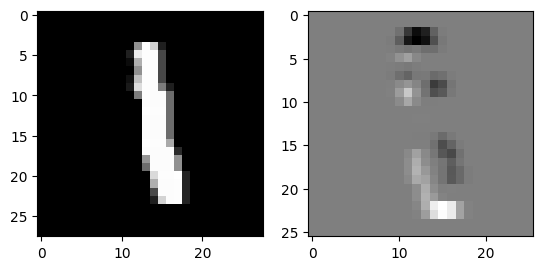

In [5]:
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms.functional import to_tensor
from matplotlib import pyplot as plt

from ml_dl_experiments.settings import settings

picture: str = settings.SOURCE_PATH + "ml_dl/CNN/img_1.png"

kernel = torch.Tensor([[[[3, 10, 3], 
                         [0, 0, 0], 
                         [-3, -10, -3]]]])

image = Image.open(picture)
image_tensor = to_tensor(image) # тензор [1, 28, 28]

# добавлено ещё одно измерение, чтобы получить [1, 1, 28, 28]
image_tensor = image_tensor.unsqueeze(0) 

result = F.conv2d(image_tensor, kernel)

# визуализация
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image, cmap = 'gray')

plt.subplot(1, 2, 2)
plt.imshow(result[0][0], cmap = 'gray') 

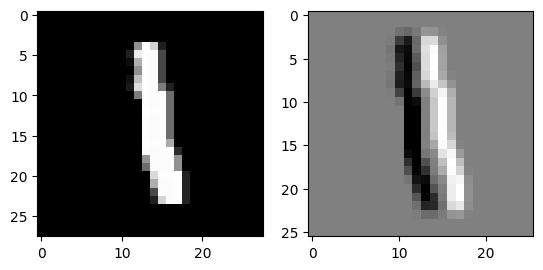

In [7]:

kernel = torch.Tensor([[[[3, 0, -3], 
                         [10, 0, -10], 
                         [3, 0, -3]]]])

image = Image.open(picture)
image_tensor = to_tensor(image) # тензор [1, 28, 28]

# добавлено ещё одно измерение, чтобы получить [1, 1, 28, 28]
image_tensor = image_tensor.unsqueeze(0) 

result = F.conv2d(image_tensor, kernel)

# визуализация
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image, cmap = 'gray')

plt.subplot(1, 2, 2)
plt.imshow(result[0][0], cmap = 'gray') 

# Свертка цветных изображений

## Ключевые отличия операции свёртки цветных изображений

- При свёртке цветного изображения каждый из трёх каналов обрабатывается независимо.
  
- Для каждого канала используется собственный фильтр.
  
- Для каждого канала получается отдельная карта признака.
  
- Итоговая карта признака — это сумма карт признака каждого канала.

Получается, что результат свёртки всегда одинаковый — сумма карт признака, или двумерная карта признака, независимо от того, поступило на вход одно- или многоканальное изображение. Разнится только количество фильтров: их нужно столько же, сколько каналов в изображении. Вот почему при обработке цветных изображений количество весов в свёрточном нейроне возрастает втрое. Эти фильтры воспринимают как единый трёхканальный фильтр, так как в результате его работы получается одна карта признака.

Благодаря отдельной обработке каждого канала, признаками могут быть углы и линии разных цветов, градиенты.

Свёрточные слои могут быть скрытыми — принимать на вход не изображение, а результаты обработки предыдущих слоёв. Результаты, в свою очередь, могут быть трёхмерными тензорами произвольной глубины. Рассмотрим, как изменится операция свёртки от повышения размерности. 

In [ ]:
from IPython.display import Video

from ml_dl_experiments.settings import settings

video: str = settings.SOURCE_PATH + "ml_dl/CNN/RGB_convolution.mp4"

# С дополнительными параметрами
Video(video, width=600, height=400, embed=True, html_attributes="muted loop autoplay")

## Свёртка тензора

Операция двухмерной (2D) свёртки conv2D работает с трёхмерными тензорами произвольной глубины. Такие тензоры имеют размерность [W, H, C], где WxH — это площадь тензора, а C — глубина. Цветное изображение — это тоже трёхмерный тензор, но с глубиной 3. Для обработки тензоров произвольной глубины используются те же принципы, что и при обработке цветных — трёхканальных — изображений:

- Для каждого канала входного тензора свой канал фильтра, отдельная операция обработки и карта признака.
  
- Итоговая карта признака — сумма карт признака отдельных каналов.

Поэтому независимо от глубины входного тензора карта признака — это матрица. Однако количество весов напрямую зависит от глубины входного тензора и вычисляется по формуле:

- Количество весов = ширина фильтра × высота фильтра × глубина входного тензора.

К примеру, для свёрточного нейрона на изображении ниже количество весов равно 3×3×4.

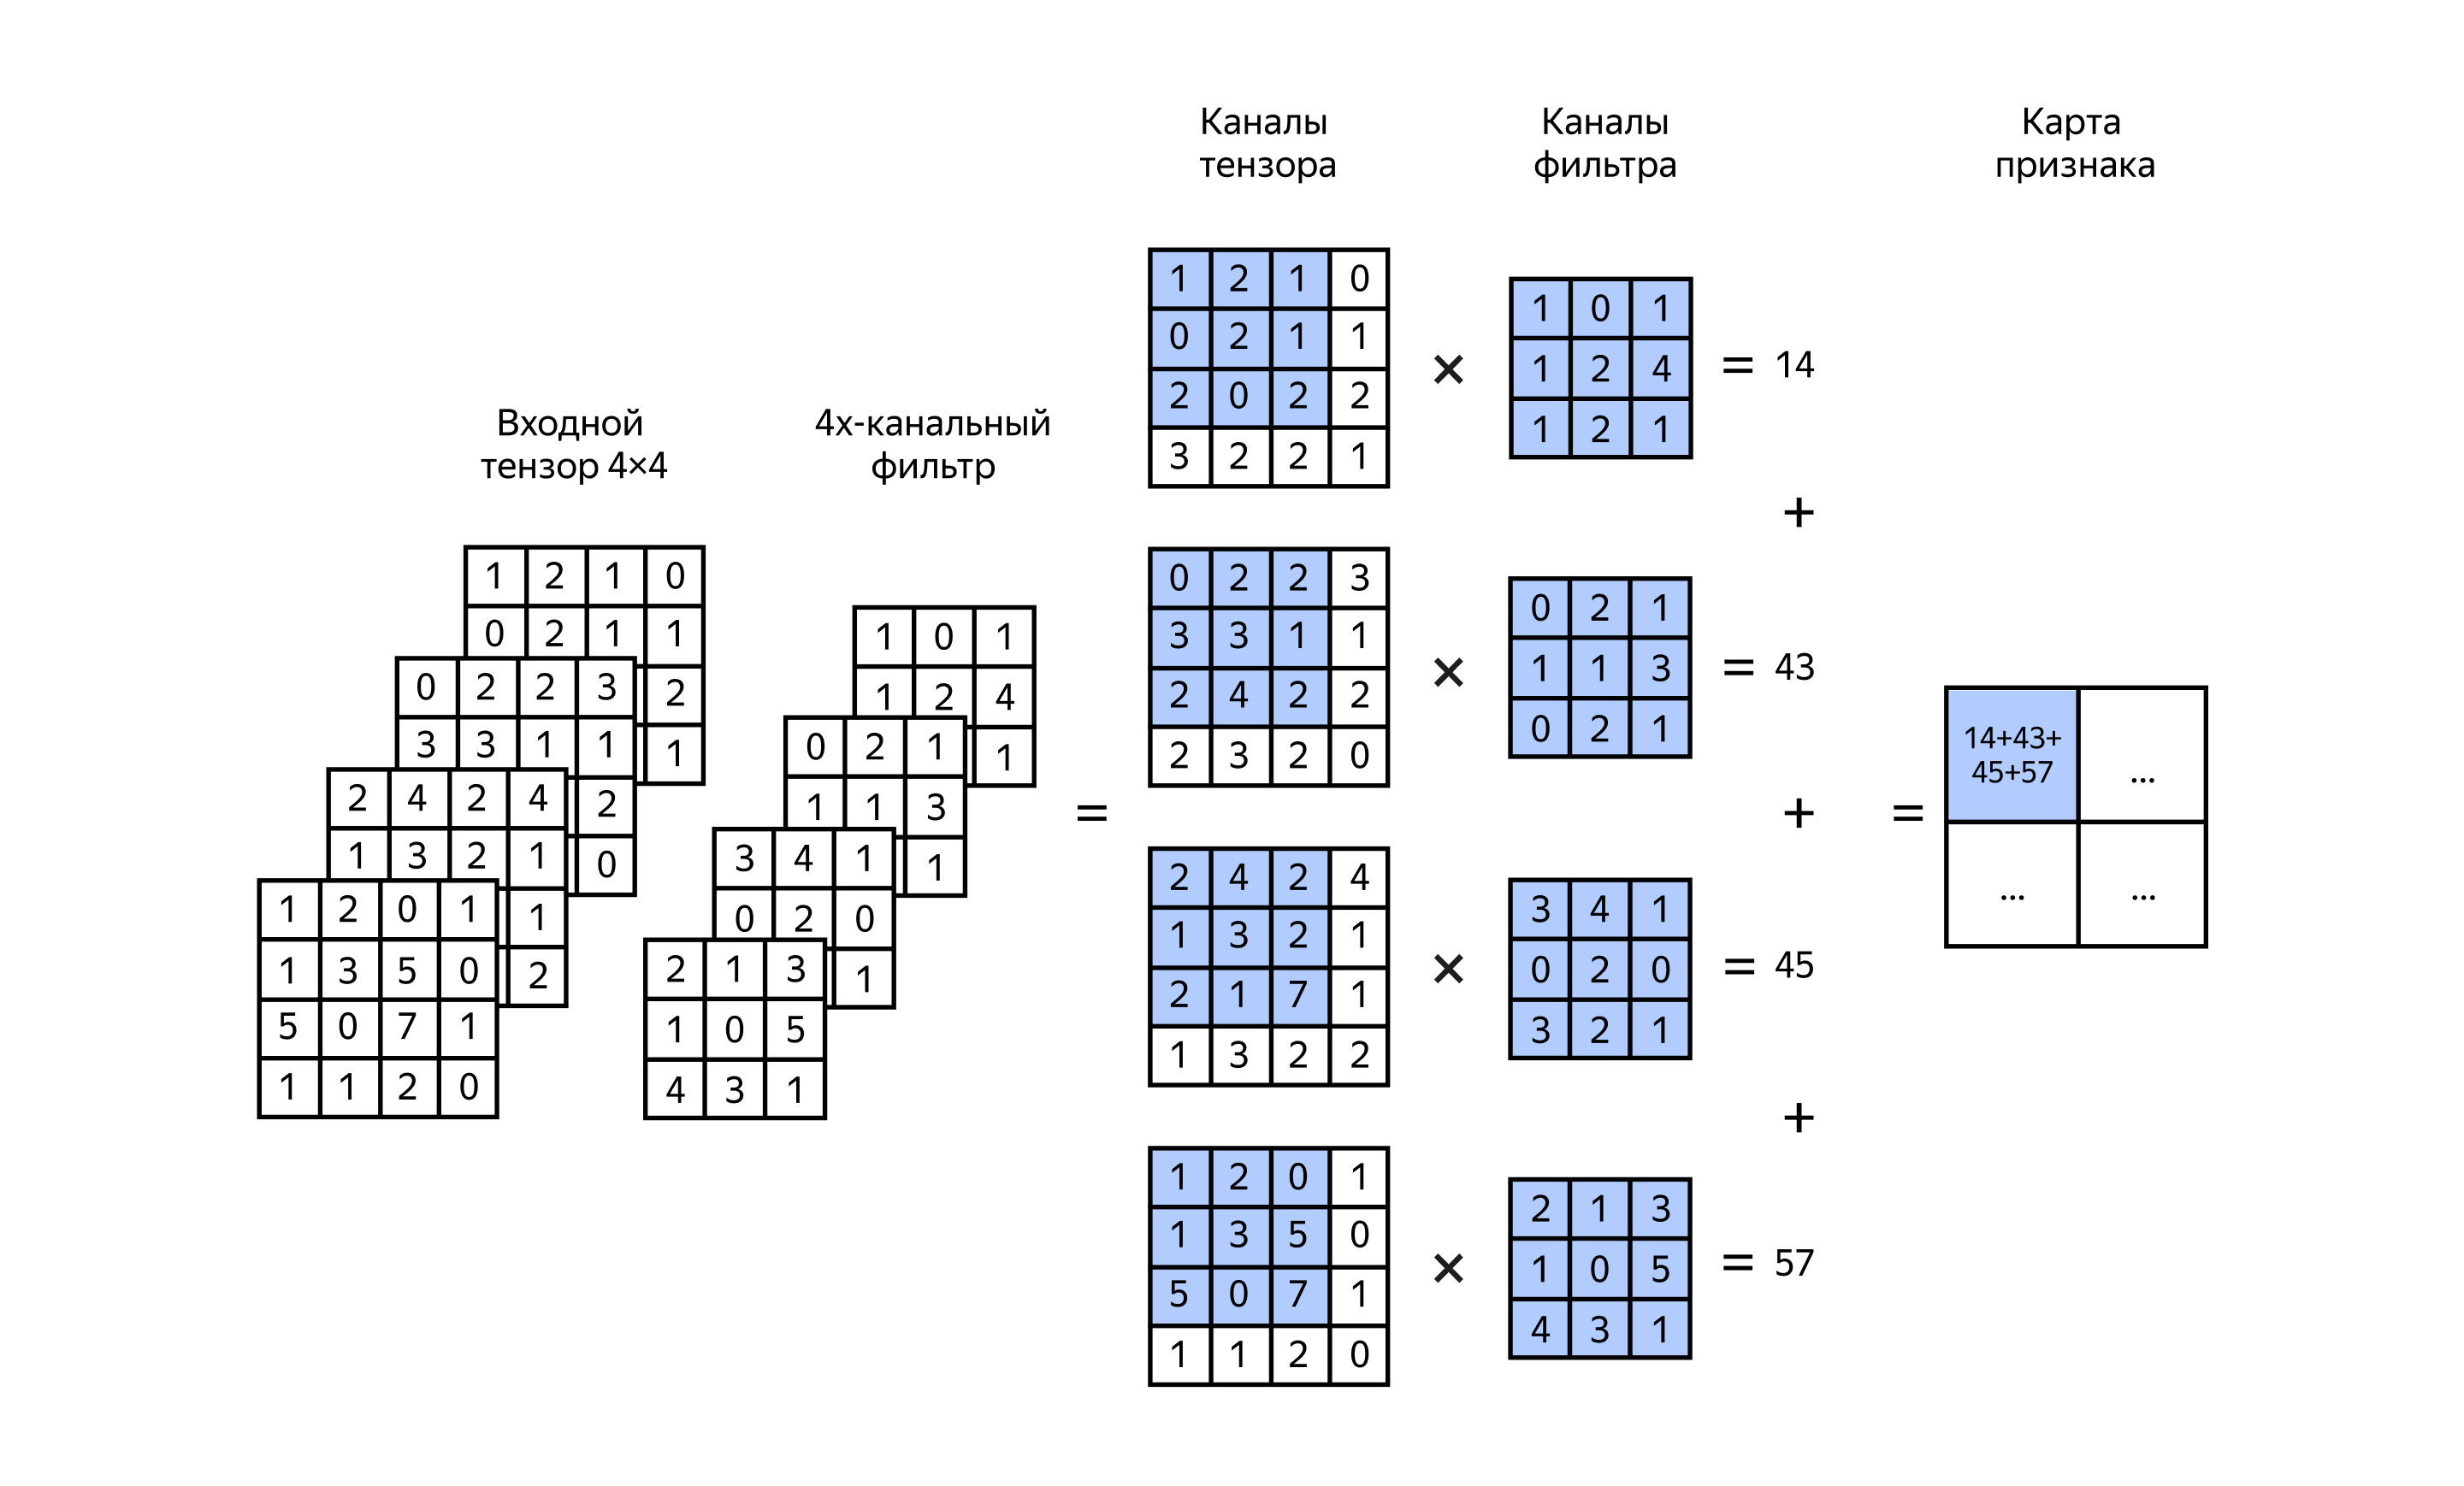

In [13]:
from IPython.display import Image
from ml_dl_experiments.settings import settings

picture: str = settings.SOURCE_PATH + "ml_dl/CNN/filter_rgb.png"

Image(picture, width=600, height=600)

По механизму операции свёртки видно, что для цветных изображений и других многоканальных входных тензоров нужны многоканальные фильтры с соответствующей глубиной. В прошлом уроке вы встречали только одноканальные фильтры, а теперь познакомитесь с многоканальными, которые обладают двумя особенностями:

- Можно задать конкретные значения фильтра для каждого из каналов. В примере ниже задан фильтр поиска горизонтальных фиолетовых линий. Поэтому первый и третий фильтр (для каналов R и B) заданы как фильтры поиска горизонтальных линий, а второй (для канала G, которого нет в фиолетовом цвете) — нулевой.

```py
kernel_3D = np.array([[[3, 10, 3],
                       [0, 0, 0],
                       [-3, -10, -3]],
                      [[0, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]],
                      [[3, 10, 3],
                       [0, 0, 0],
                       [-3, -10, -3]]])
   
kernel_3D = torch.Tensor(kernel_3D) # преобразование в pytorch-тензор
kernel_3D = kernel_3D.unsqueeze(0) # приведение к требуемой размерности [1, 3, 3, 3] 
```

- Можно объявить одноканальный фильтр и скопировать его на три канала. В примере ниже задан фильтр поиска горизонтальных линий любого цвета (то есть по любому из каналов). Для этого используется функция np.tileс параметрами (3, 1, 1), которые расшифровываются как «повторить 3 раза по оси 0, по остальным не повторять».


```py
kernel = np.array([[3, 10, 3],
                   [0, 0, 0],
                   [-3, -10, -3]])

kernel_3D = np.tile(kernel, (3, 1, 1)) # трёхмерный фильтр горизонтальных линий

kernel_3D = torch.Tensor(kernel_3D) # преобразование в pytorch-тензор 
```

```py
kernel_3D = kernel_3D.unsqueeze(0) # приведение к требуемой размерности [1, 3, 3, 3] 
```


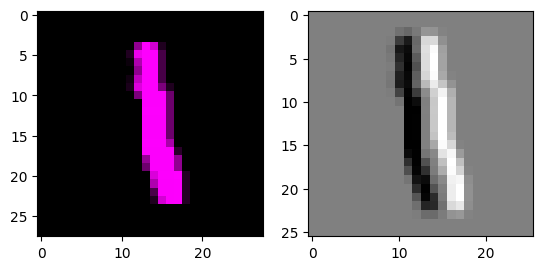

In [15]:
import torch
import numpy as np
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms.functional import to_tensor
from matplotlib import pyplot as plt

from ml_dl_experiments.settings import settings

picture: str = settings.SOURCE_PATH + "ml_dl/CNN/img_colored.png"

image = Image.open(picture) # тензор [1, 3, 28, 28]
# добавлено ещё одно измерение, чтобы получить [1, 3, 28, 28]
image_tensor = to_tensor(image).unsqueeze(0)

kernel = torch.Tensor([[[[3, 0, -3], 
                         [10, 0, -10], 
                         [3, 0, -3]]]])

kernel_3D = torch.Tensor(np.tile(kernel, (3, 1, 1))).unsqueeze(0)


result = F.conv3d(image_tensor, kernel_3D)

fig = plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.imshow(result[0][0], cmap = 'gray') 

Выделение нескольких признаков
Для распознавания изображения обычно нужно выделить не один, а несколько признаков. Например, чтобы выделить горизонтальные и вертикальные линии из цветного изображения, нужно:

- Определить две матрицы фильтров: одну для горизонтальных линий, вторую для вертикальных.
    
- Оба фильтра должны выделять линии любого цвета, а значит, должны быть трёхканальными — нужно с помощью np.tile скопировать матрицы их значений на три канала.

- Объединить два трёхканальных фильтра в общий тензор. Его размерность будет [2, 3, 3, 3]:
    - 1. 2 — количество фильтров,
    - 2. 3 — глубина фильтров,
    - 3. 3, 3 — ширина и высота фильтров.
    - Применить операцию свёртки, чтобы получить две карты признаков.

Код будет выглядеть так:


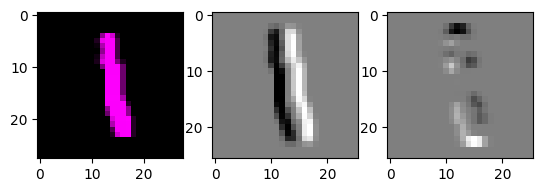

In [16]:
kernel_v = np.array([[3, 0, -3], # обычный фильтр вертикальных линий
                     [10, 0, -10],
                     [3, 0, -3]])

kernel_h = np.array([[3, 10, 3], # обычный фильтр горизонтальных линий
                     [0, 0, 0],
                     [-3, -10, -3]])

kernel_v_3D = np.tile(kernel_v, (3, 1, 1)) # трёхмерный фильтр вертикальных линий

kernel_h_3D = np.tile(kernel_h, (3, 1, 1)) # трёхмерный фильтр горизонтальных линий

kernels = torch.Tensor(np.stack([kernel_v_3D, kernel_h_3D])) # тензор с фильтрами

result = torch.nn.functional.conv2d(image_tensor, kernels)

# визуализация
fig = plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.imshow(result[0][0], cmap='gray') # карта признака вертикальных линий

plt.subplot(1, 3, 3)
plt.imshow(result[0][1], cmap='gray') # карта признака горизонтальных линий 

То же самое можно сделать с помощью свёрточного слоя из двух нейронов и функции nn.Conv2d(), в которую передаётся:

- Количество каналов входного изображения.
  
- Количество нейронов (фильтров).

- Размер фильтра (обычно указывается одно число — размер стороны квадратного фильтра).

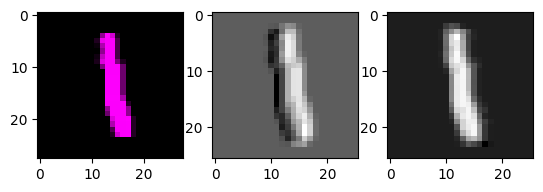

In [17]:
# Создание слоя для обработки трёхканального изображения
# двумя фильтрами
# размером 3х3
conv_layer = nn.Conv2d(3, 2, 3)

# Слой в pytorch - это функция
# Применение функции к входному изображению
# .detach() позволяет осуществить операцию
# и получить конкретные значения из pytorch-тензора.
result = conv_layer(image_tensor).detach()

# визуализация
fig = plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.imshow(result[0][0], cmap='gray') # карта признака 1

plt.subplot(1, 3, 3)
plt.imshow(result[0][1], cmap='gray') # карта признака 2 

In [18]:
conv_layer.weight

Parameter containing:
tensor([[[[-0.1365,  0.1739, -0.1451],
          [ 0.1373,  0.0801, -0.1803],
          [ 0.1571, -0.0405, -0.1884]],

         [[-0.1508, -0.0821, -0.1219],
          [ 0.0493, -0.0727,  0.1007],
          [-0.1012, -0.0609, -0.0291]],

         [[ 0.1597,  0.1802,  0.0471],
          [ 0.1417, -0.0646, -0.1878],
          [ 0.1209,  0.0327,  0.1572]]],


        [[[-0.0463,  0.1095,  0.1678],
          [ 0.0367,  0.1380,  0.1716],
          [-0.0816,  0.1256,  0.1440]],

         [[-0.1753,  0.1623,  0.0488],
          [ 0.0939, -0.1364,  0.0702],
          [-0.1672,  0.0412,  0.0099]],

         [[-0.1147,  0.1376, -0.0820],
          [ 0.1753,  0.0446, -0.0272],
          [ 0.0852, -0.1230,  0.0863]]]], requires_grad=True)

Чтобы веса нейронов стали корректными, нужно обучить этот слой как часть нейронной сети.

# 1D-, 2D-, 3D-свёртки

Всё это время мы использовали 2D-свёртку nn.Conv2d, или свёртку в двумерном пространстве, независимо от глубины входного тензора. Однако существуют и другие N-мерные свёртки: 1D nn.Conv1d и 3D nn.Conv3d. Если nn.Conv2d подходит для работы с изображениями, то nn.Conv1d и nn.Conv3d предназначены для работы с последовательностями:

- обработки текста — последовательности слов,
  
- распознавания видео — последовательности кадров,

- прогнозирования цен — временной последовательности.

Свёртки других размерностей (4D, 5D и т. д.) не реализованы в pyTorch и считаются экзотическими.

Рассмотрим механизмы 1D- и 3D-свёрток подробнее.

## 1D-свёртка

Если у 2D-свёртки для каждого канала есть 2D-фильтр, то у 1D-свёртки для каждого канала есть 1D-фильтр. В результате:

- В 2D-свёртке — матрица значений фильтра 3×3.
  
- В 1D-свёртке — вектор значений фильтра 3×1.

Этого недостаточно для обработки изображений: чтобы отыскать признаки, нужно рассматривать пиксели не только слева-справа от текущего, но и сверху-снизу. 1D-фильтр, к примеру, не способен обнаружить диагональную линию, и 1D-свёртка используется для одномерных данных (векторов, последовательностей), чтобы прогнозировать временные ряды или анализировать тексты (последовательности слов).

Слева показан входной вектор из пяти элементов. В нём красным отмечены два скользящих окна размера 3 (сначала [1, 1, 0], затем [1, 0, 1]), каждое из которых умножается поэлементно на фильтр [1, 0, 1]. Справа — выходной вектор, состоящий из одного значения 1, полученного суммированием результатов этих поэлементных умножений.

## 3D-свёртка

Кажется логичным анализировать одноканальные изображения свёрткой 2D, а многоканальные — свёрткой 3D. Но на самом деле 3D-свёртка используется для видео, где помимо осей ширины и высоты есть ось времени. Сам механизм свёртки существенно не меняется. Особенности:

- Видео обрабатываются поканально: для красного канала со всех кадров видео свой фильтр, для синего — свой.

- Входным тензором для каждой операции свёртки считается набор одноканальных изображений. Такой тензор имеет размерность [количество кадров, высота, ширина].

- Фильтр для каждого канала трёхмерный (3, 3, 3).

- Карта признака для каждого канала трёхмерная.

- Итоговая карта признаков — сумма карт признаков по каналам, а значит, тоже трёхмерная.

Такая свёртка — усложнённый вариант 2D-свёртки. В ней нужно найти признаки в каждом из каналов, а потом суммировать их. В 3D-свёртке нужно найти признаки в каждом из каналов каждого трёхкадрового фрагмента видео, а затем объединить их. Это полезно при анализе последовательностей изображений, так как позволяет рассматривать при поиске признака не только соседние пиксели на кадре, но и изменения их значений во времени.

# Параметры и гиперпараметры свёртки

В предыдущих уроках вы изучили механизм свёртки с разных сторон — узнали, как она ведёт себя на тензорах разной размерности, цветных и чёрно-белых изображениях, последовательностях. У свёрточных слоёв много достоинств, но есть и недостатки, например:

- Большое количество обучаемых параметров. Если проверить количество обучаемых параметров свёрточного слоя, их окажется немного больше, чем количество фильтров, умноженное на количество значений в фильтре.
  
- Ограниченная способность обработки изображений. Например, фильтр 3×3 не может обнаружить признак в форме пятиконечной звезды, потому что её невозможно нарисовать на 8 пикселях. То же можно сказать и про скруглённые линии.
  
- Ограниченная глубина нейросети. Ширина и высота карты признака всегда меньше, чем ширина и высота исходного изображения. Это особенность алгоритма свёртки — края и углы изображения обрезаются. Получается, когда изображение проходит свёрточные слои, ширина и высота тензора будут постепенно уменьшаться. Это ограничивает возможную глубину нейросети: если свёрточных слоёв много, то в какой-то момент будет нечего анализировать.

В этом уроке вы узнаете, как компенсировать эти недостатки. Для этого вы познакомитесь ближе с параметрами и гиперпараметрами свёрточных слоёв и научитесь их настраивать.

## Количество параметров в слое

Сначала разберёмся c количеством параметров в слое. К примеру, в коде объявлен свёрточный слой на 20 нейронов. Он работает с трёхканальными входными тензорами, анализирует их окном 3×3.

```py
import torch.nn as nn
conv_layer = nn.Conv2d(3, 20, 3) 
```

В каждом фильтре такого слоя 3⋅3⋅3=27 значений. Самих фильтров — 20. Логично предположить, что количество весов будет равно 27⋅20=540.
Посмотрим на conv_layer.weight.shape — это тензор размерности [20, 3, 3, 3], то есть состоит как раз из 540 значений.

А теперь просуммируем все параметры свёрточного слоя:

```py
print("Количество параметров слоя: ", sum(p.numel() for p in conv_layer.parameters())) 
```
Получим такой результат: 
Количество параметров слоя:  560

У каждого полносвязного нейрона есть веса, которые умножаются на входные значения и суммируются. Кроме этого, к сумме добавляется bias — смещение. Свёрточные слои работают так же, то есть к итоговой карте признака в конце добавляют смещение (поэлементно). Получается, что работа свёрточного слоя основана на стандартной операции свёртки, но адаптирована под обучение в нейросетях:  

Входная матрица 4×4 умножается на ядро 3×3 без переворота. К результату поэлементно добавляется смещение (bias) равное 5. На выходе формируется матрица 2×2.

## Схема работы свёрточного слоя

И действительно, если посмотреть conv_layer.bias.shape, то окажется, что это вектор из 20 значений — по одному смещению на нейрон.

***
Полная формула количества параметров в свёрточном слое: 
$$
N_{параметров​}=(h_{фильтра}​×w_{фильтра}​×с_{фильтра}​+bias)×N_{нейронов​}
$$
где h, w, c — высота, ширина, количество каналов фильтра соответственно.
***
Рассчитайте количество параметров в слое: `nn.Conv2d(8, 48, 3)`. 

Используем формулу расчёта количества параметров. Количество каналов фильтра зависит от количества каналов входного тензора.          

(3×3×8+1)×48=(72+1)×48=73×48=3504.

Ответ: 3504

## Размер фильтра

Для каждого свёрточного слоя мы указываем три параметра:

- количество каналов во входном тензоре — влияет на количество каналов фильтра;
  
- количество нейронов — влияет на количество фильтров;

- ширина и высота фильтра — обычно 3.

Раньше мы использовали фильтры 3×3, но можно выбрать и другой размер. К примеру, для распознавания признака, занимающего большую площадь, можно выбрать фильтр большего размера. Однако выбранный размер должен удовлетворять трём условиям. 

## Условия выбора размера фильтра

- Фильтр должен быть квадратным: ширина равна высоте. Этого правила придерживаются почти все известные архитектуры сетей. Если ширина и высота разные, то карта признаков получается тоже не квадратной и подбирать параметры дальнейших слоёв становится сложнее.
  
- Сторона фильтра — нечётное число. У такого фильтра всегда есть центральный пиксель, определяющий его текущее местоположение. Так проще считать размер выходного тензора и нет неопределённости.

- Сторона фильтра — небольшое число (3, 5, 7…). Первые свёрточные сети имели фильтры размером 11×11 и 7×7, размеры современных фильтров — 3×3, реже — 5×5. Чем меньше фильтр, тем меньше параметров у нейросети, а компенсировать размер фильтра можно глубиной, то есть количеством свёрточных слоев. Такой подход оказался эффективным.

Поэтому чаще всего вам будут встречаться фильтры 3×3 и 5×5, изредка 7×7 или частный случай 1×1. Остальные можно считать экзотикой.

## Как глубина компенсирует маленькие фильтры

Обычно фильтры больше, чем 3×3, выбирают для входных слоёв, чтобы нейросеть могла выделить более сложные базовые признаки с исходного изображения. Это полезно, к примеру, в медицинских задачах, поскольку биологические структуры (мышцы, нервы, капилляры) обычно состоят из сложных кривых и детали их формы очень важны. Примеры таких задач: распознавание опухолей по рентгену, определение пневмонии по флюорограмме.

В остальных случаях размер фильтра компенсируется глубиной нейросети. К примеру, нужно распознать, есть ли пятиконечная звезда на изображении. Свёрточный слой с фильтрами 3×3 на это не способен, потому что площадь такой звезды больше, чем 3×3 пикселя. Он выделит в качестве признаков только отдельные детали звезды: диагональные, вертикальные, горизонтальные прямые. Следующий свёрточный слой получит на вход уже не пиксели изображения, а информацию о том, что в одном небольшом регионе есть скопление вертикальных, горизонтальных и диагональных линий. На основании этого он сделает вывод, что на изображении есть звёздочка.

Чтобы лучше понять, как два фильтра 3×3 могут компенсировать один 5×5, посмотрите на схему:

Рецептивное поле двух фильтров 3×3
Нижняя матрица имеет размер 5×5. Свернув её фильтром 3×3, получим новую матрицу, но уже размера 3×3. Её можно свернуть ещё одним фильтром 3×3. И тогда, так же как и для фильтра 5×5, в итоговой карте признака мы получим одно значение. Получается, два последовательных фильтра 3×3 «видят» такой же объём входных пикселей (имеют такое же рецептивное поле), как и один фильтр 5×5.
Благодаря этому эффекту два фильтра 3×3 способны заменить один фильтр 5×5. Кроме того, в фильтре 5×5 минимум 25 параметров, а в двух фильтрах 3×3 всего 9 + 9 = 18, так что при подходе с двумя последовательными небольшими фильтрами мы хорошо экономим на количестве весов.

# Особенности операции свёртки фильтром большего размера

## Сильное увеличение количества параметров.

Рассмотрим операцию на примере фильтра 5×5. 

Чтобы задать размер фильтра, нужно заменить последний параметр в nn.Conv2d(3, 20, 3).

Например, для слоя с фильтрами 5×5: nn.Conv2d(3, 20, 5). Количество параметров вырастет, оно будет равно (5⋅5×⋅3+1)⋅20=1520. В слое nn.Conv2d(3, 20, 3) параметров было 560, так что изменение размера фильтра заметно увеличивает количество параметров.

## Уменьшение карты признаков. 

В результате свёртки 3×3 карта признаков всегда была немного меньше по ширине и высоте, чем исходное изображение. 
Рассчитать, как изменится ширина и высота тензора после свёртки, можно по формуле:
$$
H_{карты}​=H_{тензора}​−H_{фильтра}​+1
$$
Аналогично для ширины. Например, если исходное изображение было 5×5, то после свёртки 3×3 получится карта признака 3×3.

Из тензора 14×14 после свёртки фильтром 5×5 получится карта 10×10.
Если увеличить размер фильтра, итоговая карта признаков уменьшится ещё сильнее. Например, возьмём фильтр 5×5. Для исходного изображения 5×5 карта признаков будет размера 1×1. Если изображение 14×14, то карта признаков 10×10.

Так происходит из-за особенностей операции свёртки. Этот неприятный эффект мешает наращивать глубину свёрточных слоёв и уменьшает влияние пикселей в углах и на краях изображения. Если пиксель находится в углу, он поучаствует только в одном шаге свёртки, дальше окно сместится. Если фильтр находится в центре изображения, то для свёртки фильтром 3×3 он поучаствует в 8 шагах.
***
Хорошая новость в том, что для проблем уменьшения площади тензора и несправедливой потери информации с краёв изображения есть решение. Это решение — padding (пэддинг).
***
## Как пэддинг компенсирует уменьшение карты признаков

>**Пэддинг — это добавление нулевых пикселей по краям изображения, чтобы компенсировать уменьшение, которое произойдёт из-за операции свёртки.**

In [30]:
from IPython.display import Video

from ml_dl_experiments.settings import settings

video: str = settings.SOURCE_PATH + "ml_dl/CNN/CNN_padding.mp4"

# С дополнительными параметрами
Video(video, width=480, height=200, embed=True, html_attributes="muted loop autoplay")


Пэддинг можно указать в параметре padding свёрточного слоя nn.Conv2d(). 

Возможные значения:

- Целое число — сколько столбцов и строк нулевых пикселей добавить к каждой стороне изображения. На визуализации выше padding=1.
  
- ‘valid’ — без пэддинга.

- ‘same’ — добавить столько нулей, чтобы площадь итоговой карты признака была равна площади исходного изображения, то есть padding=(hфильтра​−1)/2.

Если используется пэддинг, то размер карты признаков меняется так:
$$
H_{карты​}=H_{тензора}​−H_{фильтра}+1+2⋅padding.
$$

Пэддинг помогает сохранить площадь карты признаков и тем самым учесть детали на границах изображения. Иногда важна не точность, а скорость, в этих случаях используют другой параметр — **страйд**.

## Страйд
***
**Страйд** — это расстояние, на которое сдвигается окно свёртки на каждом шаге. 
***
В предыдущих примерах страйд равнялся 1, поэтому при выполнении операции окно свёртки перемещалось или на 1 пиксель влево, или на один пиксель вниз. Но можно задать и другое значение страйда. На схеме показана разница в перемещении скользящего окна при операции свёртки, если страйд равен 1 и 2.

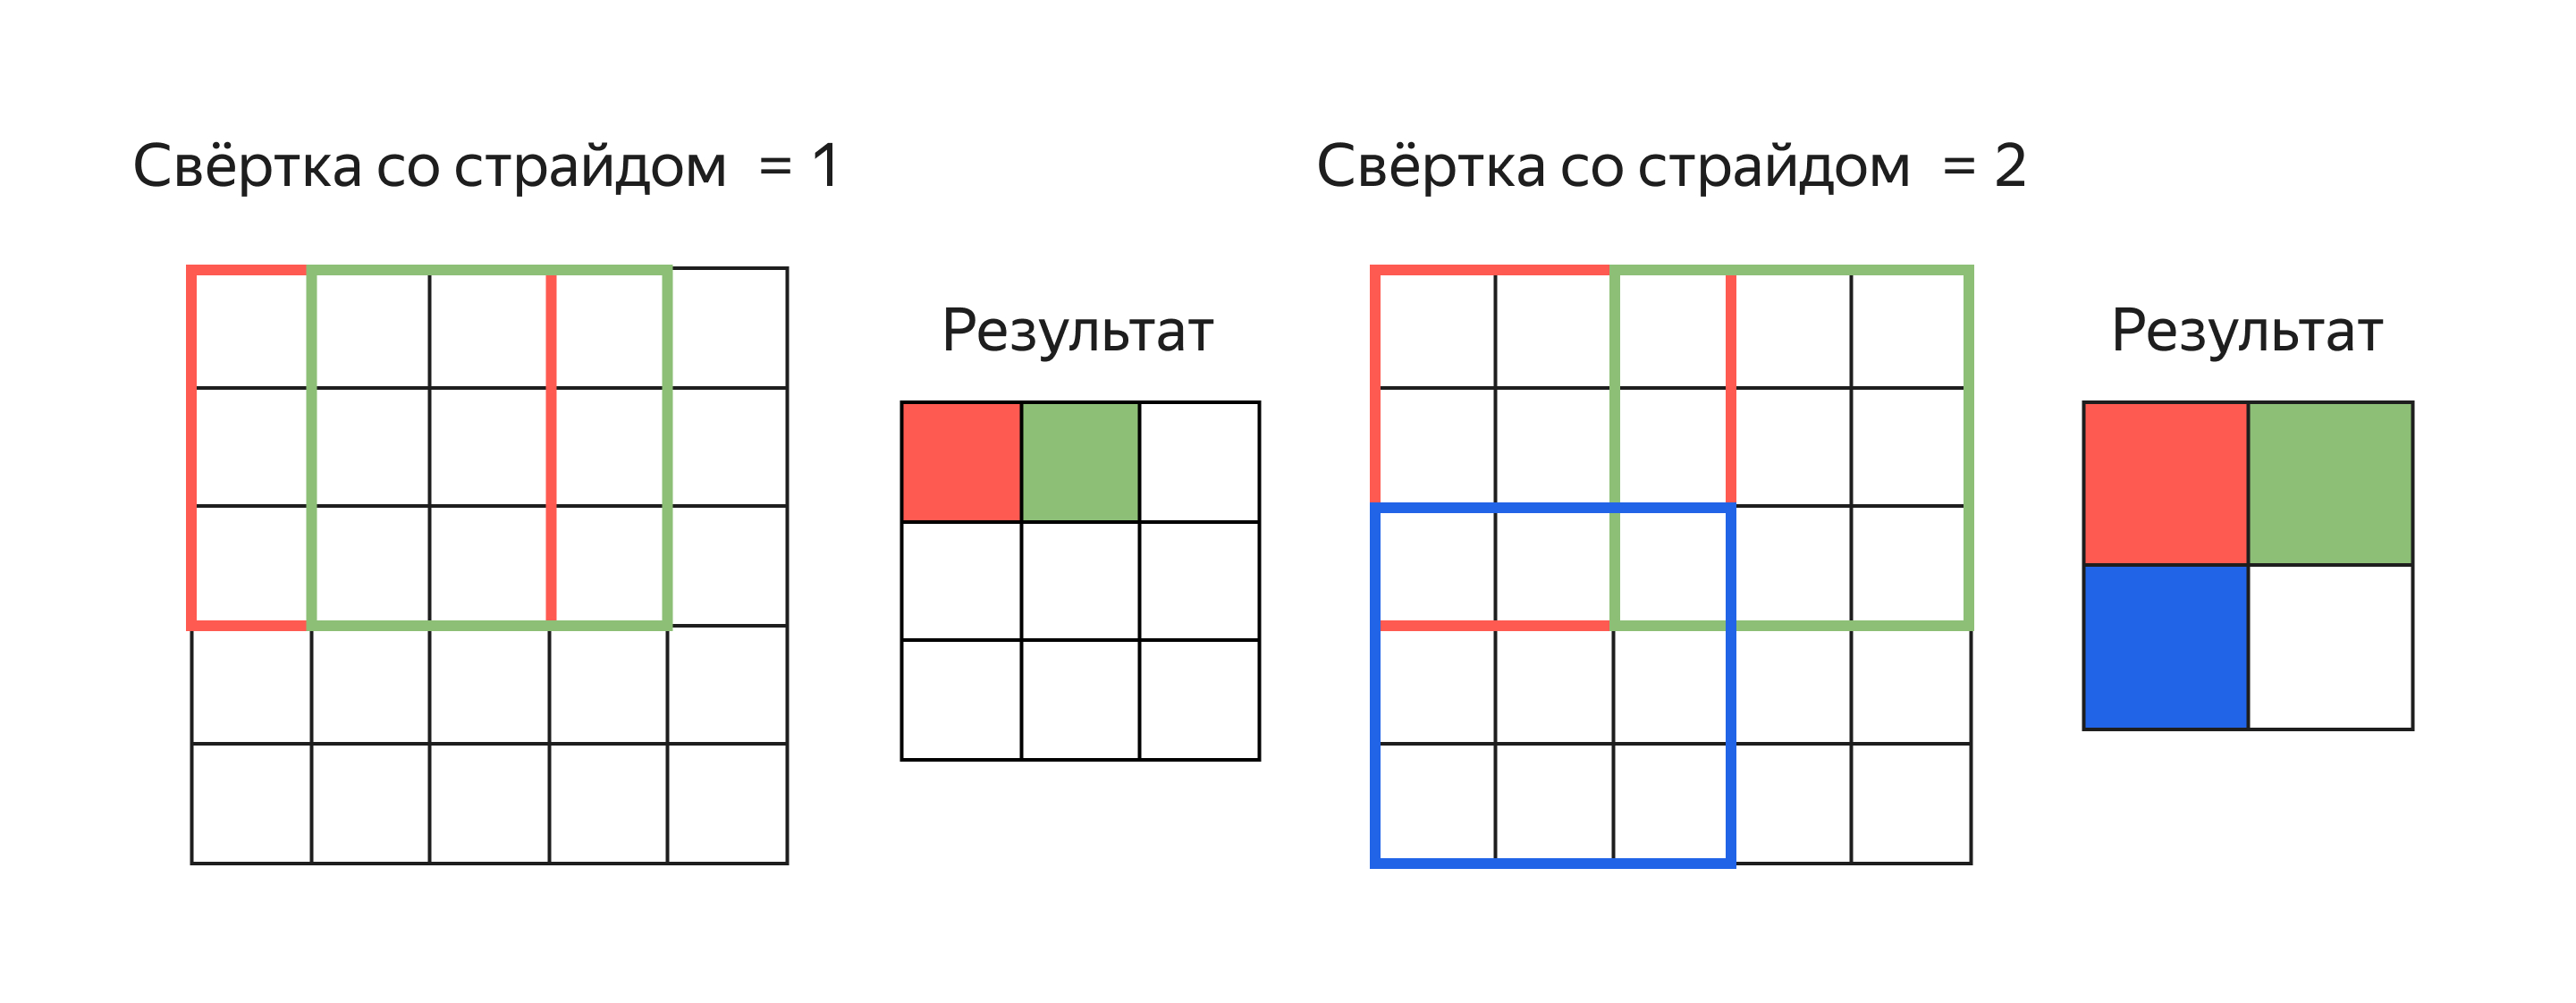

In [32]:
from IPython.display import Image

image: str = settings.SOURCE_PATH + "ml_dl/CNN/stride.png"

# С дополнительными параметрами
Image(image, width=480, height=200)

Страйд, больший 1, уменьшает размер выходной карты признаков, а значит, на следующий слой поступит меньше информации, её обработка займёт меньше времени. Это полезно в системах, которые должны обрабатывать большие изображения в реальном времени.

С другой стороны, если шаг больше 1, то каждый пиксель попадёт в меньшее количество шагов свёртки и некоторые детали изображения могут быть упущены. Обычно страйд меньше или равен размеру фильтра, чтобы каждый пиксель попал хотя бы в один шаг свёртки.

При добавлении страйда размер итоговой карты признаков рассчитывается так:
$$
H_{карты​}=floor(\frac{H_{тензора​}−H_{фильтра​}+2⋅padding​}{stride})+1,
$$
где floor() — округление в меньшую сторону.

К примеру, рассчитаем высоту карты для изображения выше со страйдом 2: 

25−3+0​+1=2.

Особенности реализации в коде 

- В слое nn.Conv2d этот параметр указывается как stride=2.
    
- Если stride больше 1, параметр padding='same' не поддерживается.

# Пулинг и его гиперпараметры

Пулинг — это уплотнение карты признака. Для этого, как и в свёртке, используется скользящее окно. Значения карты признака, попавшие в окно, заменяются на одно число. Таким образом можно, например, превратить регион 2×2 в одно значение, то есть уменьшить количество значений в 4 раза.

То, как именно заменить группу значений на одно, определяется видом пулинга. На визуализации ниже представлен самый популярный вид — мaкс-пулинг, в котором группа значений в окне заменяется на их максимум.

Алгоритм операции пулинга на примере макс-пулинга:

- Определить размер скользящего окна, разместить его в верхнем левом углу карты признака.
  
- Рассчитать максимум значений внутри окна, записать его в итоговый результат.

- Сдвинуть окно вправо; если некуда сдвигать вправо — сдвинуть вниз.

- Повторять шаги 2-3, пока не будет обработана вся карта признака.

## Пулинг в разных размерностях

Как и свёртка, пулинг может применяться к многоканальным тензорам, быть 1D, 2D, 3D. В многоканальных тензорах пулинг применяется отдельно к каждому каналу. В результате применения пулинга уменьшается ширина и высота тензора, но количество каналов не меняется.

Рассмотренный выше пулинг — 2D. 1D и 3D ведут себя схоже с 1D и 3D свёрткой:

- 1D пулинг заменяет вектор на одно значение.
  
- 2D пулинг заменяет квадратный регион на одно значение.
   
- 3D пулинг заменяет кубический регион на одно значение.

Они применяются в паре с соответствующими свёртками в тех же задачах — распознавании последовательностей.

## Гиперпараметры пулинга

В отличие от операции свёртки, у пулинга нет параметров — весов. Соответственно, слои пулинга не обучаются. Но в них есть гиперпараметры, аналогичные тем, что используются в свёртке:

- размер скользящего окна (аналог размера фильтра);
- страйд;
- паддинг.

Однако политика выбора гиперпараметров отличается. Рассмотрим её для каждого гиперпараметра.

- **Размер скользящего окна — обычно 2×2**. 1×1 — бессмысленно, 3×3 и более приводят к потере слишком большого количества информации. Пулинг 2×2 сокращает 4 значения до 1, то есть в 4 раза уменьшает количество информации. Пулинг 3×3 — уже в 9. Основная задача пулинга — уменьшить количество информации без потерь в качестве, поэтому выбирается минимальный размер скользящего окна.

- **Страйд — обычно 2**. Если использовать страйд, равным 1, то количество значений в тензоре почти не уменьшится в результате пулинга. А значит, не будет достигнута основная цель этой операции — сокращение размера тензора. Если выбрать страйд больше размера скользящего окна (страйд 3 для окна 2×2), то некоторые значения входного тензора не попадут ни в один шаг окна пулинга и будут полностью пропущены.

- **Пэддинг** — дополняет изображение со всех сторон, как и в случае свёртки, только вместо 0 используются значения, которые не повлияют на результат пулинга. К примеру, для макс-пулинга края изображения дополняются минус бесконечностями. Используется редко: в случаях, когда входной тензор имеет нечётные размеры (например, 11×11), и пулинг окном 2×2 может привести к потере важной информации на границах.

Формула расчёта размера результата пулинга выглядит так же, как и для свёртки:
$$
H_{результата}=floor(\frac{H_{тензора​}−H_{фильтра​}+2⋅padding​}{stride})+1,
$$
Для ширины аналогично.

В PyTorch пулинг реализован в виде слоя nn.MaxPool2d(), который принимает параметры:

- kernel_size — размер скользящего окна;

- stride — страйд, по умолчанию равен kernel_size;
    
- padding — пэддинг, по умолчанию 0.

В коде его применение выглядит так:

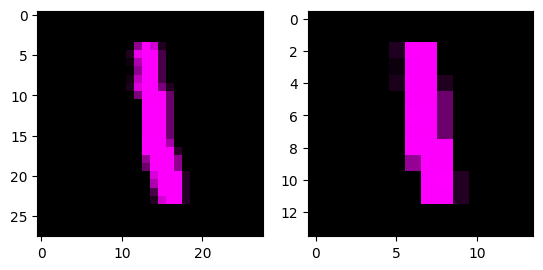

In [34]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_tensor
import torch.nn as nn

image = Image.open(settings.SOURCE_PATH + "ml_dl/CNN/img_colored.png")
image_tensor = to_tensor(image)
# добавлено ещё одно измерение, чтобы получить [1, 3, 28, 28]
image_tensor = image_tensor.unsqueeze(0)

pool_layer = nn.MaxPool2d(2) # объявление слоя пулинга с окном 2х2, страйдом 2

result = pool_layer(image_tensor).detach()

# визуализация
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
# результат - трёхканальный тензор [3, 14, 14]
# plt.imshow ожидает изображение в формате [высота, ширина, количество каналов]
# поэтому используется permute, чтобы привести [3, 14, 14] к [14, 14, 3]
plt.imshow(result[0].permute(1, 2, 0))

Виды пулинга
Чаще всего в свёрточных нейросетях используется макс-пулинг, онако есть и другие виды пулинга:

- Min — из значений в окне выбирается минимальное. Практически не используется для обработки изображений.
  
- Average — из значений в окне выбирается среднее. Использовался до макс-пулинга, иногда бывает полезен в задачах классификации. В отличие от макс-пулинга, сохраняет не только самые яркие признаки, но и учитывает другие признаки региона. Однако в подавляющем большинстве случаев макс-пулинг работает лучше. Усредняя информацию, average-пулинг сглаживает её, поэтому в результате получается размытая карта признаков — она более устойчива к шумам, но содержит менее чёткие признаки.

- Отдельно выделим глобальный пулинг (Global Pooling). Это особый вид пулинга, помогающий радикально сократить размер тензора. Для этого он применяется не к региону карты признака, попавшему в скользящее окно, а к карте целиком. Эта операция аналогична обычному пулингу, если бы размер окна был равен размеру карты признака. В результате из карты признака получается одно значение.

Глобальный пулинг обычно применяют перед полносвязными слоями, чтобы сократить количество весов в последних.

Без глобального пулинга из свёрточного слоя получили тензор 5×5×20. Если преобразовать его в плоский вектор для обработки полносвязным слоем, получится 500 признаков. Тогда весов в полносвязном слое должно быть примерно $500\cdot N_{нейронов}.$

С глобальным пулингом из свёрточного слоя получили тензор 5×5×20. После глобального пулинга получили тензор 1×1×20. Это плоский вектор на 20 признаков. Тогда весов в полносвязном слое должно быть примерно $20\cdot N_{нейронов}$. 

Получилось уменьшить количество весов в 25 раз. Разумеется, часть информации была потеряна, потому что физический смысл глобального пулинга — убрать данные о местоположении признака, но оставить — о его отсутствии/наличии и степени проявленности.

Глобальный пулинг тоже бывает Max и `Average` — они работают так же, как и в обычном пулинге. Единственная разница — `Global Average Pooling `используется чаще, чем Global Max Pooling, потому что на практике чаще показывает лучший результат.

В PyTorch глобальный пулинг не реализован как отдельный инструмент, но для этого можно использовать слой `nn.AdaptiveAvgPool2d(1)`, где 1 — это как раз ширина и высота итоговой карты признаков. Используется он полностью аналогично обычным слоям пулинга, только результат всегда будет иметь размерность [1, X, 1, 1], где X — это количество карт признаков.

Так почему используется именно пулинг и как он помогает улучшить качество работы нейросети?

## Уплотнение признаков

Свёрточные нейросети, как и любые глубокие сети, склонны к переобучению. В них так много параметров, что они могут не обобщать информацию и искать тренды, а попросту запомнить весь датасет. И пулинг как раз препятствует переобучению — оказывает регуляризационный эффект. Пулинг помогает сохранить и выделить важную информацию и отбросить лишнее. 

Это можно назвать уплотнением признаков, то есть мы стараемся сохранить признаки, но уменьшить пространство для их хранения.

На изначальном изображении слишком много деталей для распознавания. На карте признака сохранены только необходимые, но проявлены блекло. На карте признака после пулинга важные детали ярко выделены.

Так и работает пулинг — он сгущает, уплотняет признаки в более компактном пространстве. Из-за этого приходится отказаться от мелких и зачастую неважных деталей, но благодаря этому нейросеть не переобучится на шуме. Именно поэтому пулинг помогает нейросети обобщить данные, а не зазубрить.

Глобальный пулинг добивается этого ещё радикальнее, удаляя информацию о местоположении признака на фото. Однако, оказывается, если нейросеть достаточно глубокая, то чем дальше от входного слоя, тем менее важны становятся пространственные зависимости. Если мы оперируем признаками верхнего уровня: лицами, домами, машинами, а не углами и линиями, то их положение не так важно. Достаточно знать, есть они на фото или нет.

Обычно пулинг располагается после свёрточного слоя. Исходное изображение и, соответственно, карта признака большие по площади, поэтому применён пулинг nn.MaxPool2d(4), чтобы существенно уменьшить их размер.

На изначальном изображении слишком много деталей для распознавания. На карте признака сохранены только необходимые, но проявлены блекло. На карте признака после пулинга важные детали ярко выделены.

Так и работает пулинг — он сгущает, уплотняет признаки в более компактном пространстве. Из-за этого приходится отказаться от мелких и зачастую неважных деталей, но благодаря этому нейросеть не переобучится на шуме. Именно поэтому пулинг помогает нейросети обобщить данные, а не зазубрить.

Глобальный пулинг добивается этого ещё радикальнее, удаляя информацию о местоположении признака на фото. Однако, оказывается, если нейросеть достаточно глубокая, то чем дальше от входного слоя, тем менее важны становятся пространственные зависимости. Если мы оперируем признаками верхнего уровня: лицами, домами, машинами, а не углами и линиями, то их положение не так важно.

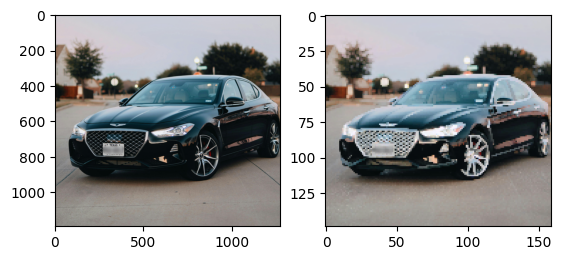

In [3]:
from matplotlib import pyplot as plt
from ml_dl_experiments.settings import settings
from torchvision.transforms.functional import to_tensor
from PIL import Image
import torch
import torch.nn as nn

picture: str = settings.SOURCE_PATH + "ml_dl/CNN/car.png"

image = Image.open(picture)
image_tensor = to_tensor(image).unsqueeze(0)
# ваш код для приведения тензора изображения к подходящей размерности
pool_layer = nn.MaxPool2d(8)
result = pool_layer(image_tensor).detach()

# визуализация
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.imshow(result[0].permute(1, 2, 0))

Изображение стало в 64 раза меньше, но все важные признаки компактно сохранены.